In [1]:
# useful visualisation and numerical tools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
vx = np.loadtxt("../homework1/vx.dat", skiprows=1)
vy = np.loadtxt("../homework1/vy.dat", skiprows=1)
vz = np.loadtxt("../homework1/vz.dat", skiprows=1)

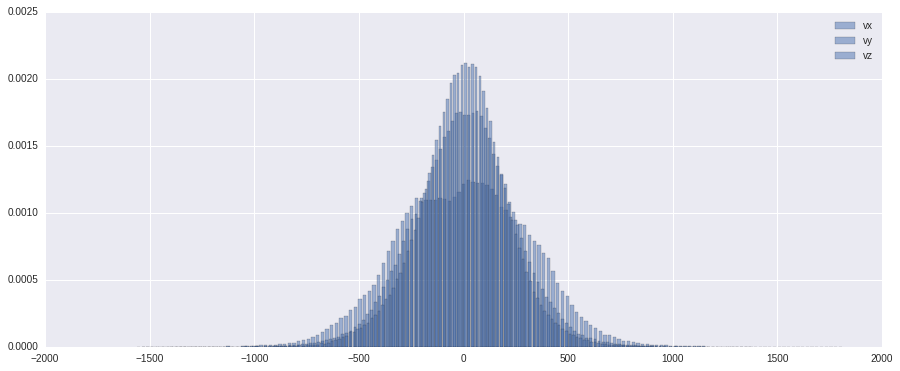

In [3]:
# Let's histogram the data, because the sample is too large
def hist(data, bins, normed=True):
    counts, bin_edges = np.histogram(data, bins=bins, normed=normed)
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2.  # midpoints of all bins (instead of bin edges)
    return bin_centres, counts

nbins = 150
# h_vx_unnormed = hist(vx, bins=nbins, normed=False)
h_vx = hist(vx, bins=nbins, normed=True)
h_vy = hist(vy, bins=nbins, normed=True)
h_vz = hist(vz, bins=nbins, normed=True)

def plot_hist(hist, alpha=1.0, label=''):
    width = 0.7 * (hist[0][1] - hist[0][0])  # bar width < bin width (for visual clarity)
    plt.bar(hist[0], hist[1], align='center', width=width, alpha=alpha, label=label)
    
plot_hist(h_vx, alpha=.5, label='vx')
plot_hist(h_vy, alpha=.5, label='vy')
plot_hist(h_vz, alpha=.5, label='vz')
plt.legend()

$$K(u) = \frac{3}{4} \left(1-u^2 \right) I_{|u| \leq 1},$$

with $I_A = 1 \mbox{ if } x \in A \mbox{ and 0 otherwise}$

In [4]:
def Epanechnikov(*u):
    """ Epanechnikov kernel function with u in [-1, 1] range
    =======
    params:
    u - argument being a number, multiple numbers or an array.
    Possible invocations:
        Epanechnikov(-1)
        Epanechnikov(1,2)
        Epanechnikov([-1,0,1])        
    """
    u = np.asarray(u[0]) if len(u) == 1 else np.asarray(u)
    if np.shape(u) == ():  # if u is a number
        if np.abs(u) <= 1.0:
            return 0.75 * (1 - u ** 2)
        return 0        
    return np.array([0.75 * (1 - ui ** 2) if np.abs(ui) <= 1.0 else 0 for ui in u])    # if u is an array

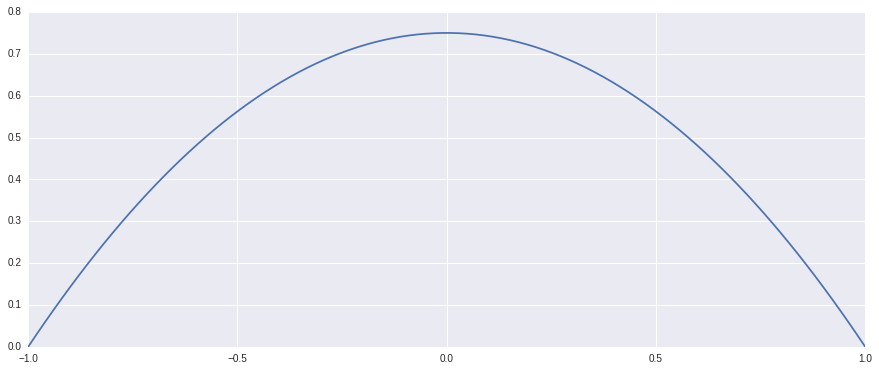

In [5]:
# let's visualise the Epanechnikov function
xx = np.linspace(-1, 1, 100)
plt.plot(xx, Epanechnikov(xx))

In case of histogrammed data the normalisation becomes...

In [6]:
def kde(x, data, K, h, debug=False):
    """Kernel Density Estimation
    =======
    params:
    x    - argument of kde
    data - data vector (shape (number_of_datapoints,)) or normalised histogram with data[0] - bin centres
           and data[1] - bin contents
    K    - Kernel function
    h    - smoothing parameter for the Kernel function (bandwidth)
    """
    if np.shape(data[0]) == ():  # in case of datapoints (not histogram)
        return 1 / (len(data) * h) * sum(K((x - xi) / h) for xi in data)
    # in case of histogram
    N = len(data[1])
    tot_counts = sum(data[1])
    if debug:
        print "total counts: ", tot_counts
        print "Bandwidth h: ", h
        print "N bins: ", N
    return 1 / h / tot_counts * sum(K((x - data[0][i]) / h) * data[1][i] for i in range(N))

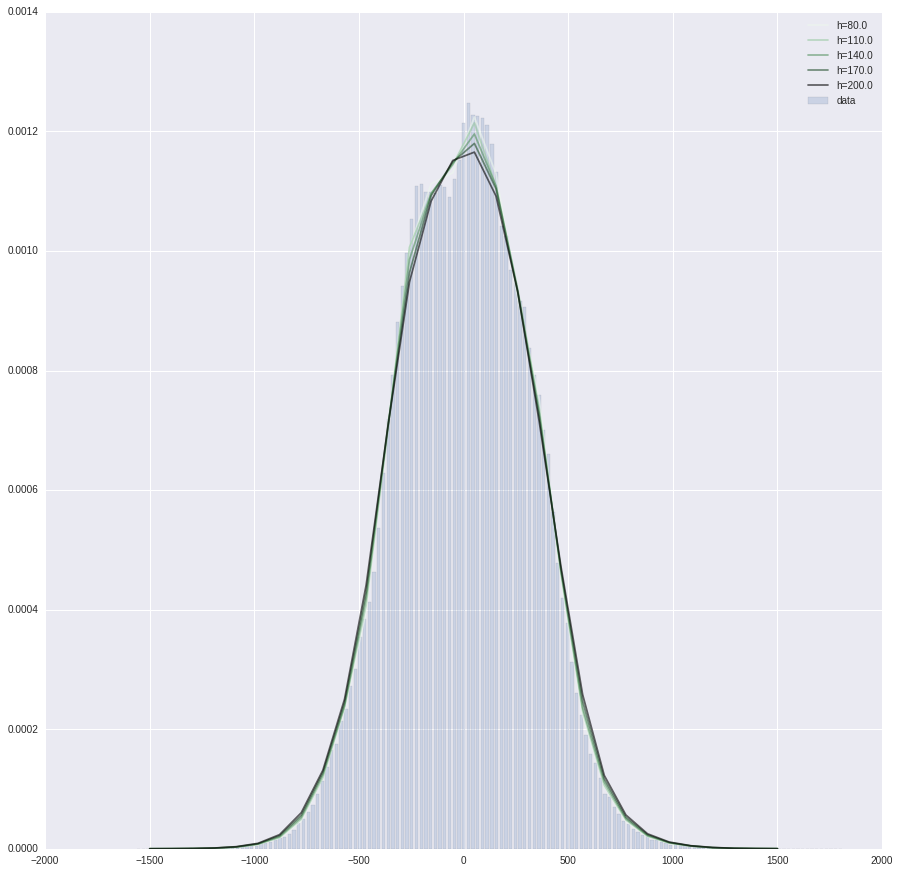

In [36]:
# sns.set_palette(sns.light_palette("green"))
def scan_bandwidth(h_data, hs, x_ax = np.linspace(-1500,1500,30), debug=False):
    """
    params:
    =======
    h_data - histogrammed data
    hs     - array-like with bandwidth candidates
    """
    # sns.set_palette(sns.cubehelix_palette(npoints, start=2, rot=0, dark=0, light=.95, reverse=False))
    # sns.set_palette(sns.light_palette("navy", reverse=True))
    with sns.cubehelix_palette(len(hs), start=2, rot=0, dark=0, light=.95, reverse=False):
        for h in hs:
            kde_res = kde(x_ax, h_data, Epanechnikov, h=h)
            if debug:
                print "kde results:\n", kde_res
            plt.plot(x_ax, kde_res, label='h={0}'.format(h), alpha=.6)
    plot_hist(h_data, alpha=0.2, label='data')
    plt.legend()

# Case of vx
hs = np.linspace(80., 200., 5)    
scan_bandwidth(h_data=h_vx, hs=hs)    

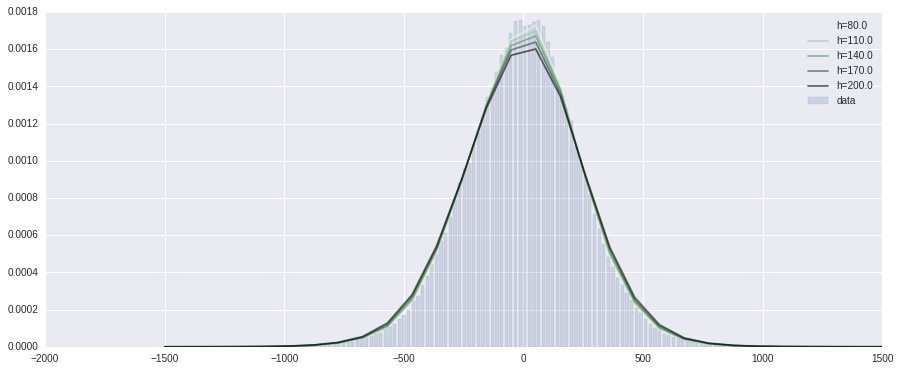

In [8]:
# Case of vy
hs = np.linspace(80., 200., 5)    
scan_bandwidth(h_data=h_vy, hs=hs)   

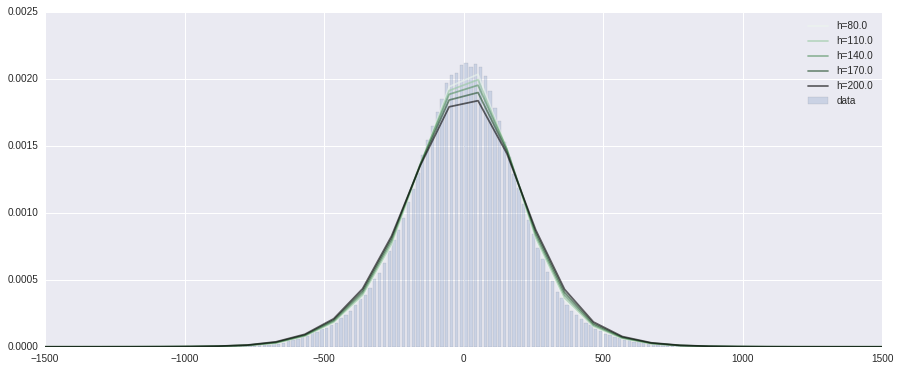

In [9]:
# Case of vz
hs = np.linspace(80., 200., 5)    
scan_bandwidth(h_data=h_vz, hs=hs)   

As we can see above -- the smaller the bandwidth, $h$, the more sensitive the KDE is to statistical fluctuations and hence it yields less general result (i.e. the result better fits the data, but is more prone to be false in case of another sample from the same distribution).

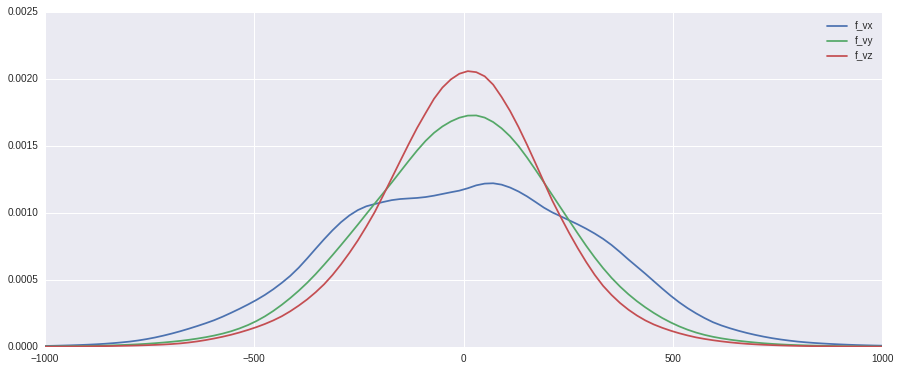

In [10]:
# Define f_vx, f_vy and f_vz with fixed bandwith, for convenience
def f_vx(x):
    return kde(x, h_vx, Epanechnikov, h=100.)

def f_vy(x):
    return kde(x, h_vy, Epanechnikov, h=100.)

def f_vz(x):
    return kde(x, h_vz, Epanechnikov, h=100.)

xx = np.linspace(-1000, 1000, 100)
plt.plot(xx, f_vx(xx), label='f_vx')
plt.plot(xx, f_vy(xx), label='f_vy')
plt.plot(xx, f_vz(xx), label='f_vz')
plt.legend()

# check normalisation of f_vx, f_vy, f_vz
# from scipy.integrate import quad
# for f_vi in [f_vx, f_vy, f_vz]:
#     print "Normalisation of ", f_vi, " : ", quad(f_vi, -1500, 1500) 

True
True
True


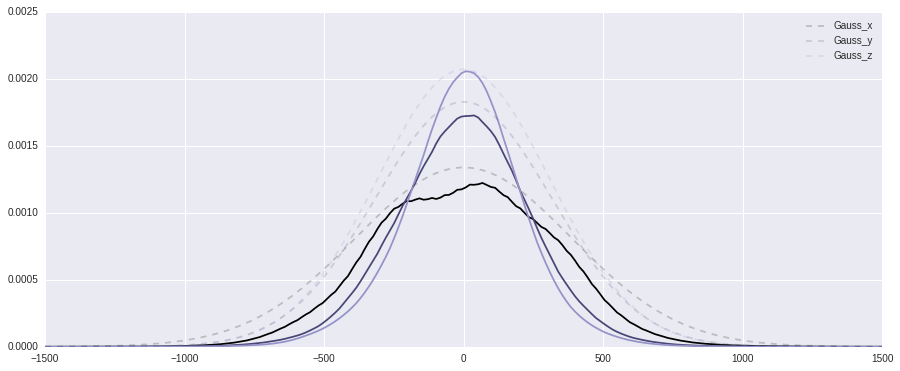

In [11]:
def gaussian(x, mu, var):
    return 1 / np.sqrt(2 * np.pi) / np.sqrt(var) * np.exp(-(x - mu) ** 2 / 2 / var)

# xx = np.linspace(-1200, 1200, 20)
xx = np.linspace(-1500, 1500, 200)

with sns.cubehelix_palette(3, start=0, rot=0, dark=0, light=.6, reverse=True):
    plt.plot(xx, f_vx(xx))
    plt.plot(xx, f_vy(xx))
    plt.plot(xx, f_vz(xx))

var_x, var_y, var_z = 150000, 100000, 95000  # let us try these values
def gx(x):
    return gaussian(x, 0, var_x)

def gy(x):
    return gaussian(x, 0, var_y)

def gz(x):
    return gaussian(x, 0, var_z)

# same M_i because it's possible and simpler
Mx, My, Mz = 1.3, 1.45, 1.6

with sns.cubehelix_palette(3, start=2, rot=0, dark=0, light=.6, reverse=True):
    plt.plot(xx, Mx * gx(xx), linestyle='--', label='Gauss_x', alpha=.2)
    plt.plot(xx, My * gy(xx), linestyle='--', label='Gauss_y', alpha=.2)
    plt.plot(xx, Mz * gz(xx), linestyle='--', label='Gauss_z', alpha=.2)
plt.legend()

# check whether Gaussians are always greater / equal than p.d.f.'s
print np.all(f_vx(xx) <= Mx * gx(xx) )
print np.all(f_vy(xx) <= My * gy(xx) )
print np.all(f_vz(xx) <= Mz * gz(xx) )

In [23]:
# define Box-Muller
def get_box_muller(size=1, mus=(0,0), sigs2=(1,1)):
    """Generate size # of pairs of independent normal random variables of specified mean
       (mus) and variance (sigs2) according to the Box-Muller
       transform"""
    u = np.random.random_sample((size, 2)) # ~ U(0,1) sample of shape `size` x 2 (corresponds to u1 and u2)
    R = np.sqrt(-2 * np.log(u[:, 0]))
    z1 = R * np.cos(2 * np.pi * u[:, 1])
    z2 = R * np.sin(2 * np.pi * u[:, 1])    
    return z1 * np.sqrt(sigs2[0]) + mus[0], z2 * np.sqrt(sigs2[1]) + mus[1]
    
mc_samples = 10000

np.random.seed(4) ## DEBUG
# (1) take u ~ U(0,1) and the Gaussians
u = np.random.random_sample(mc_samples)
qx = get_box_muller(size=mc_samples/2, mus=(0,0), sigs2=(var_x, var_x))  # shape: 2 x mc_samples/2
qy = get_box_muller(size=mc_samples/2, mus=(0,0), sigs2=(var_y, var_y))  # shape: 2 x mc_samples/2
qz = get_box_muller(size=mc_samples/2, mus=(0,0), sigs2=(var_z, var_z))  # shape: 2 x mc_samples/2
qx = np.reshape(qx, newshape=(mc_samples,))
qy = np.reshape(qy, newshape=(mc_samples,))
qz = np.reshape(qz, newshape=(mc_samples,))

# (2) Accept / reject
u_smaller_vx = u <= f_vx(qx) / (Mx * gx(qx))
u_smaller_vy = u <= f_vy(qy) / (My * gy(qy))
u_smaller_vz = u <= f_vz(qz) / (Mz * gz(qz))
sample_fvx = np.array([ qx[i] for i in range(len(qx)) if u_smaller_vx[i]])
sample_fvy = np.array([ qy[i] for i in range(len(qy)) if u_smaller_vy[i]])
sample_fvz = np.array([ qz[i] for i in range(len(qz)) if u_smaller_vz[i]])

# xx = np.linspace(-1500, 1500, 200)

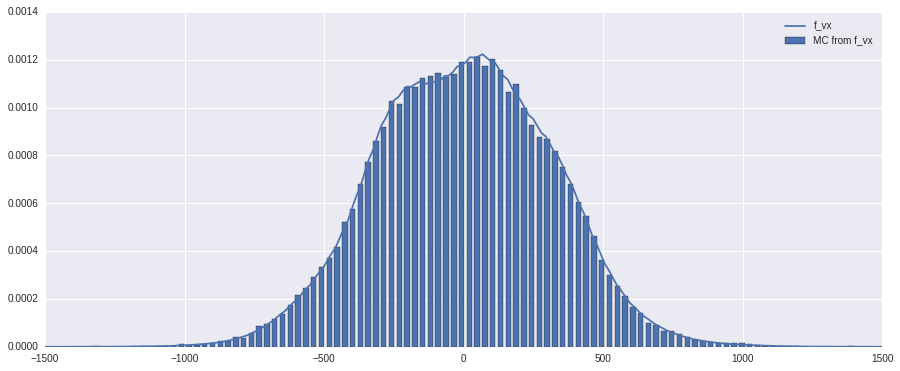

In [24]:
# MC from f_vx
plot_hist(hist(sample_fvx, bins=100, normed=True), alpha=1.0, label='MC from f_vx')
plt.plot(xx, f_vx(xx), label='f_vx')
plt.legend()

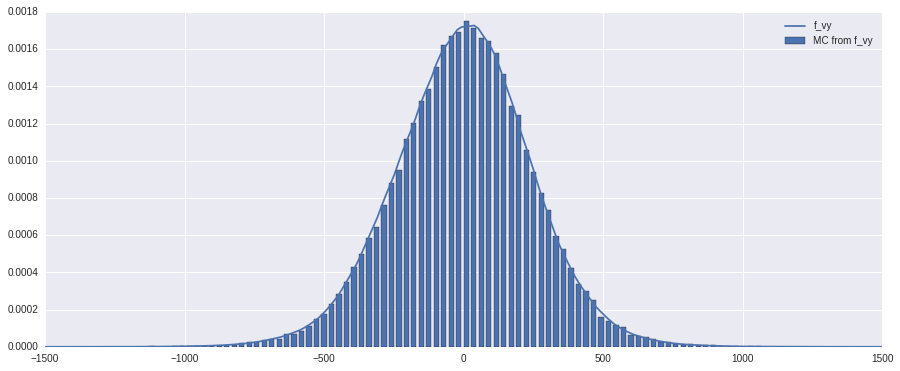

In [25]:
# MC from f_vy
plot_hist(hist(sample_fvy, bins=100, normed=True), alpha=1.0, label='MC from f_vy')
plt.plot(xx, f_vy(xx), label='f_vy')
plt.legend()

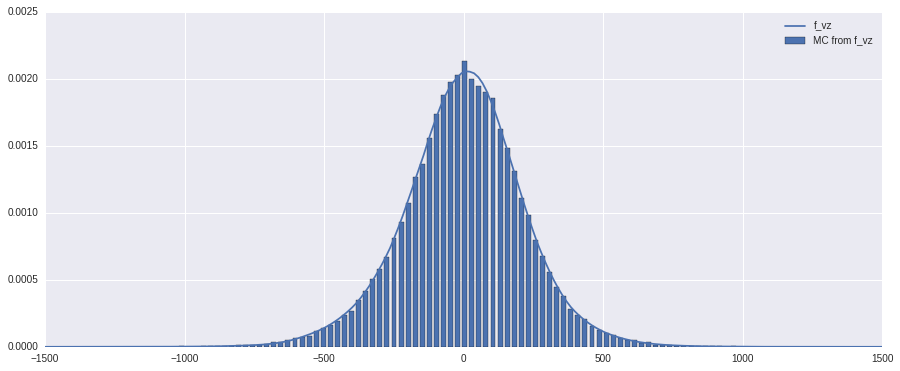

In [26]:
# MC from f_vz
plot_hist(hist(sample_fvz, bins=100, normed=True), alpha=1.0, label='MC from f_vz')
plt.plot(xx, f_vz(xx), label='f_vz')
plt.legend()

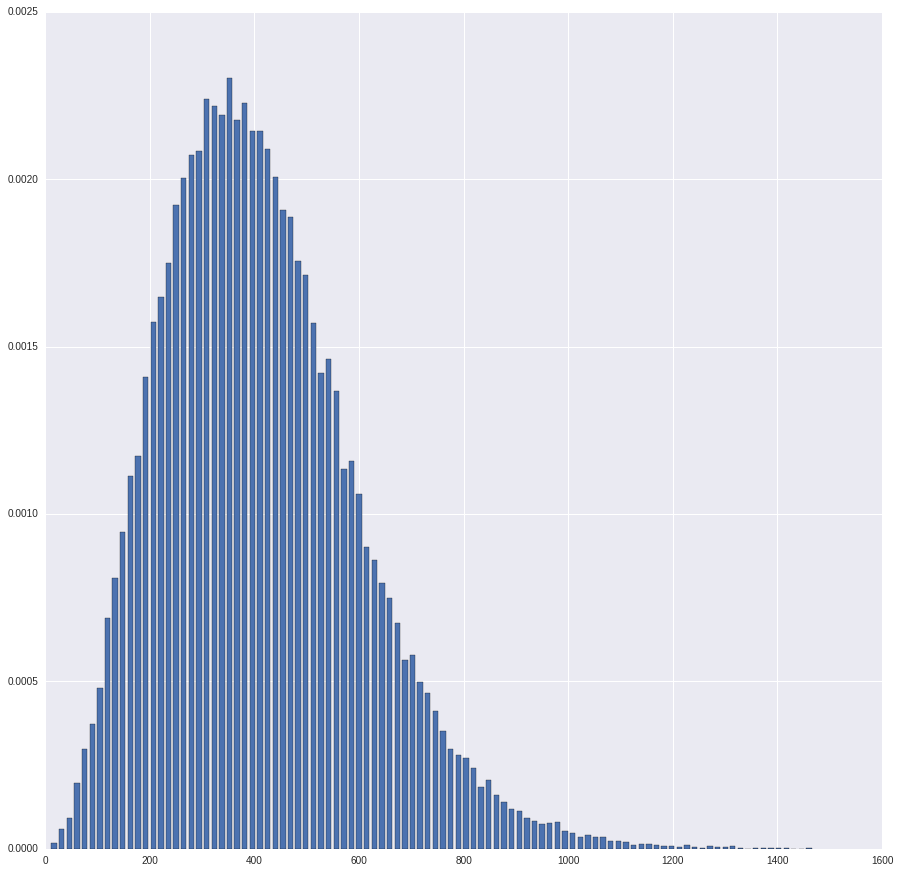

In [39]:
# p.d.f. of v = sqrt(vx^2 + vy^2 + vz^2)
size = np.min([len(sample_fvx), len(sample_fvy), len(sample_fvz)])
sample_v = np.sqrt(sample_fvx[0:size] ** 2 + sample_fvy[0:size] ** 2 + sample_fvz[0:size] ** 2)
h_v = hist(sample_v, bins=100, normed=True)
plot_hist(v_hist, alpha=1.0, label='MC of v')

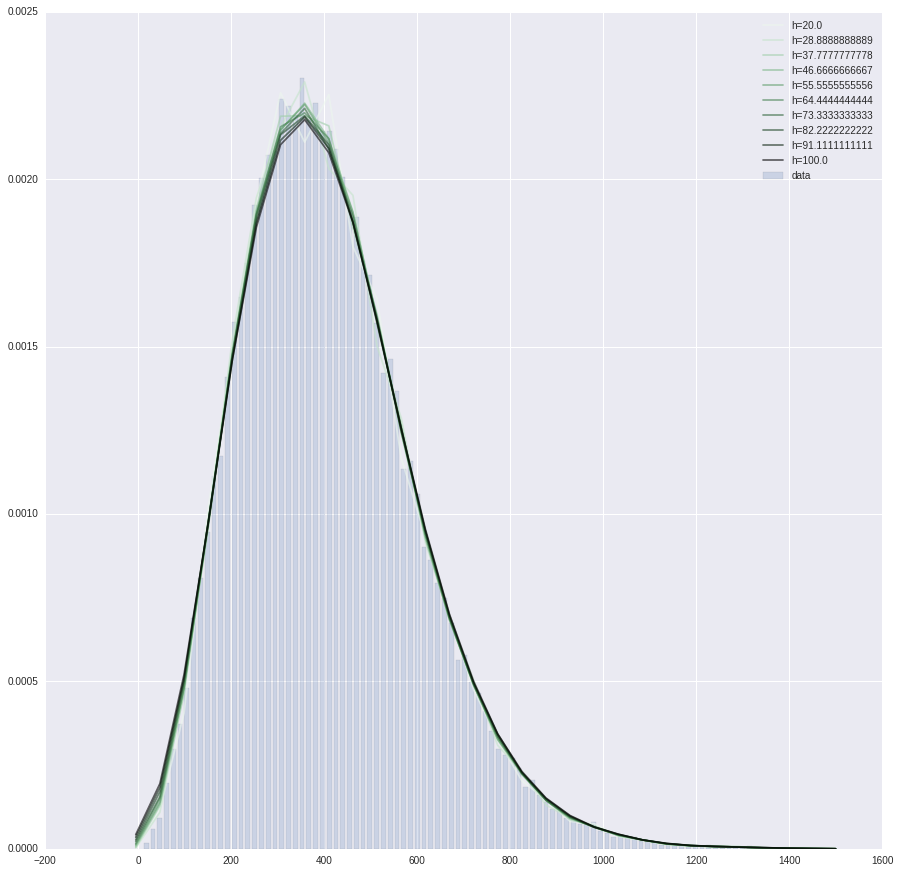

In [40]:
# let us fit a model using KDE
pylab.rcParams['figure.figsize'] = (15, 15)
hs = np.linspace(20., 100., 10)    
scan_bandwidth(h_data=h_v, hs=hs, x_ax=np.linspace(-5,1500,30))  

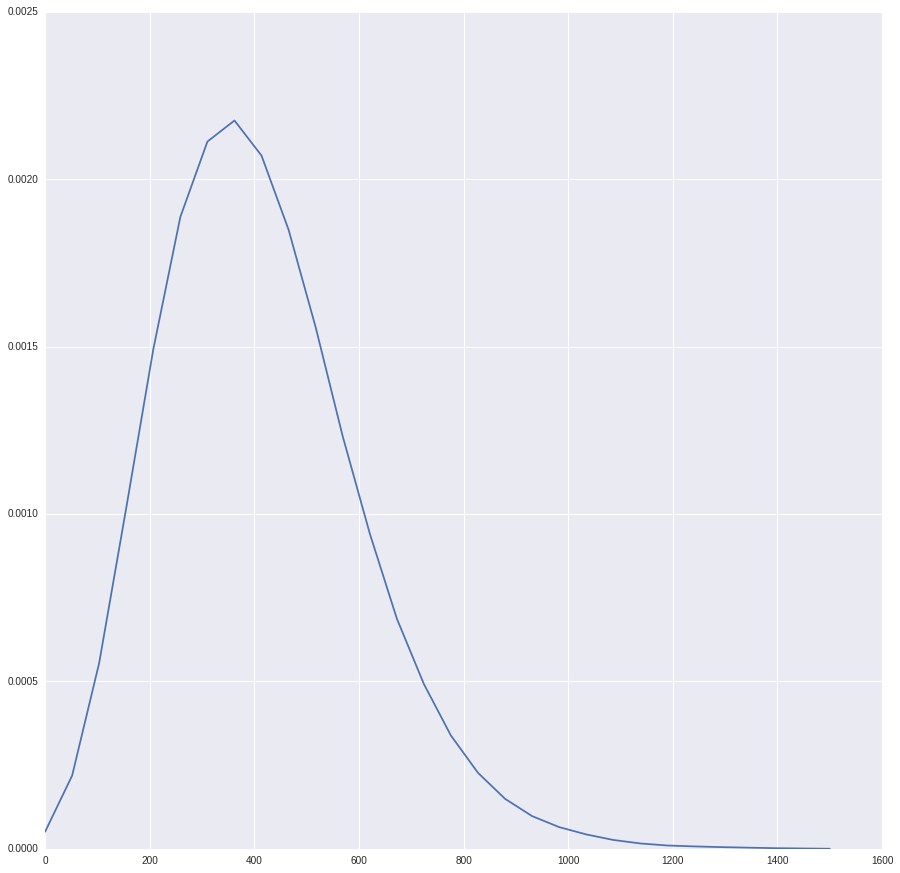

In [42]:
def f_v(x):
    return kde(x, h_v, Epanechnikov, h=100.)

xx = np.linspace(0, 1500, 30)
plt.plot(xx, f_v(xx))